In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint_adjoint
from torchdiffeq import odeint

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Action

The Wilson gauge action is given as

$$
S_{latt}^E [U]= - \beta \sum_{n} Re [P_{\mu\nu}(n)]
$$

($\mu < \nu$) with the plaquette

$$
P_{\mu\nu}(n) = U_{\mu}(n)  U_{\nu}(n+\mu)  U_{\mu}^{\dagger}(n+\nu)  U_{\nu}^{\dagger}(n).
$$

$U_{\mu}(n)$ in U(1)

In 2D, each lattice site has two links. We save these in the form (batch size | 2 | grid size | grid size) such that the 2 links are treated as two channels in image processing.

In 2D, the only plaquettes are $P_{01}$

We use periodic BCs

In [6]:
grid_size = 8

In [7]:
def calc_plaquettes(U,u1_bool=True):
    if u1_bool:
        plaquettes = torch.zeros((U.shape[0], grid_size, grid_size), dtype=torch.cfloat)
        plaquettes = (U[:,0,:,:] * torch.roll(U[:,1,:,:], -1, dims=1)
                      * torch.roll(U[:,0,:,:], -1, dims=2).conj() * U[:,1,:,:].conj())
    else: # In this case U is actually theta and not U
        plaquettes = torch.zeros(U.shape[0], grid_size, grid_size)
        plaquettes = (U[:,0,:,:] + torch.roll(U[:,1,:,:], -1, dims=1)
                      - torch.roll(U[:,0,:,:], -1, dims=2) - U[:,1,:,:])
    return plaquettes

In [8]:
def action(U, beta=1., u1_bool=True):
    plaquettes = calc_plaquettes(U, u1_bool)
    return - beta * torch.sum(plaquettes.real, dim=(1,2))

In [9]:
# Generate initial configurations from a uniform distribution
def generate_initial_configs(n):
    # n ... batch size
    init = torch.rand((n,2,grid_size,grid_size), device=device, dtype=torch.cfloat) * 2. - (1.+1.j)
    return init / init.abs()

### Observables

In [10]:
def action_mean_func(samples, beta):
    return action(samples, beta=beta).numpy().mean()

In [11]:
def plaq_squared_real_func(samples):
    return (calc_plaquettes(samples)**2).numpy().mean().real

In [12]:
def plaq_squared_imag_func(samples):
    return (calc_plaquettes(samples)**2).numpy().mean().imag

In [13]:
def topological_charge(U):
    plaquettes = calc_plaquettes(U, u1_bool=True)
    plaquettes = u_to_theta(plaquettes)
    plaquettes = (plaquettes+np.pi) % (2.*np.pi) - np.pi
    return torch.sum(plaquettes, dim=(1,2)) / (2.*np.pi)

In [14]:
def topological_susceptibility(U):
    topo_charge = topological_charge(U)
    return (topo_charge**2).numpy().mean()

In [15]:
def jackknife(dataset, observable_fct):
    n = dataset.shape[0]
    expectation_value = observable_fct(dataset)
    
    observables = np.zeros([n])
    for i in range(n):
        dataset = torch.roll(dataset, -1, 0)
        dataset_i = dataset[:-2]
        observables[i] = observable_fct(dataset_i)
        
    variance = np.sum((observables - expectation_value)**2) * (n - 1.) / n
    std_dev = np.sqrt(variance)
    return expectation_value, std_dev

Switch representations:

In [16]:
def u_to_theta(u):
    return (-1.j*torch.log(u)).real

In [17]:
def theta_to_u(theta):
    return torch.exp(1.j*theta)

# U1 Runge Kutta

For:

$$
\frac{dy}{dt} = f(t,y)
$$

Def RK 4:

$$
y_{n+1} = \frac{h}{6} (k_1+2k_2+2k_3+k_4)
$$

$$
t_{n+1} = t_n+h
$$

$$
k_1 = f(t_n,y_n) \\
k_2 = f(t_n+\frac{h}{2},y_n+k_1\frac{h}{2}) \\
k_3 = f(t_n+\frac{h}{2},y_n+k_2\frac{h}{2}) \\
k_4 = f(t_n+h,y_n+k_3h)
$$

In [18]:
def runge_kutta_theta(init, f, step_size, t0, t1):
    t = torch.arange(t0,t1,step_size)
    for i in range(t.shape[0]):
        k1 = f(t[i], init)
        k2 = f(t[i] + step_size/2., init + k1 * step_size/2.)
        k3 = f(t[i] + step_size/2., init + k2 * step_size/2.)
        k4 = f(t[i] + step_size, init + k3 * step_size)
        init = init + step_size / 6. * (k1 + (2.*k2) + (2.*k3) + k4)
    return init

For gauge fields:

$$
\frac{dV_t}{dt} = Z(V_t) V_t
$$

RK 3:

$$
V_{t+\epsilon} = \exp(i (\frac{3}{4}Z_2 - \frac{8}{9}Z_1 + \frac{17}{36}Z_0))W_2 \\
W_0 = V_t\\
W_1 = \exp(i\frac{1}{4}Z_0)W_0 \\
W_2 = \exp(i(\frac{8}{9}Z_1 - \frac{17}{36}Z_0))W_1\\
Z_i = \epsilon Z (W_i)
$$

In [19]:
def runge_kutta_u1(init, Z, step_size, t0, t1):
    t = torch.arange(t0,t1,step_size)
    for i in range(t.shape[0]):
        w0 = init
        Z0 = Z(t[i], w0)
        w1 = w0 * torch.exp(1.j * step_size * Z0 / 4.)
        Z1 = Z(t[i], w1)
        w2 = w1 * torch.exp(1.j * step_size * (8. * Z1 / 9. - 17. * Z0 / 36.))
        Z2 = Z(t[i], w2)
        init = w2 * torch.exp(1.j * step_size * (3. * Z2 / 4. - 8. * Z1 / 9. + 17. * Z0 / 36.))
    return init

# Diffusion process

In [20]:
sigma = torch.tensor(25., device=device)

In [21]:
# Diffusion coefficient g(t) of the forward SDE at time t
def diff_coeff(t):
    return sigma**t

In [22]:
# Standard deviation of p_0t at time t
def p_0t_standard_deviation(t):
    return torch.sqrt( (sigma**(2. * t) - 1.) / (2. * torch.log(sigma)) )

In [23]:
# Factor of the dt term in the reverse ODE
def reverse_ode_score_func(t, x):
    t_batch = torch.ones((x.shape[0],1), device=device) * t
    sigma_t = diff_coeff(t)
    network.eval()
    with torch.no_grad():
        score = network(x, t_batch)
    return - sigma_t**2 / 2. * score

In [24]:
# generate samples by solving the reverse ODE
def solve_ode(n, t_end=1e-5):
    init_config = generate_initial_configs(n)
    solution = runge_kutta_u1(init_config, reverse_ode_score_func, -5e-3, 1., t_end)
    return solution

In [25]:
# generate samples by solving the reverse SDE
def solve_sde(n, dt=1e-3):
    init_config = generate_initial_configs(n)
    for i in range(int(1.//dt)):
        t = 1. - i * dt
        t_batch = torch.ones((init_config.shape[0],1), device=device) * t
        network.eval()
        with torch.no_grad():
            score = network(init_config, t_batch)
        drift_term = - diff_coeff(t)**2 * score
        init_config = init_config * torch.exp(1.j * ((-1.*dt) * drift_term + 
                                              np.sqrt(dt) * diff_coeff(t) * torch.randn_like(score)))
        
    return init_config

# Training definition

In [26]:
# Defining the loss function for given x_0 sampled from p_0
def score_loss_function(x_0):
    eps = 1e-5
    t = torch.rand((x_0.shape[0], 1), device=device) * (1. - eps) + eps #Second part for numerical stability
    lam_sqrt = p_0t_standard_deviation(t).view(x_0.shape[0],1,1,1)
    std_normal_dist = torch.randn(x_0.shape, device=device)
    x_t = x_0 * torch.exp(1.j * lam_sqrt * std_normal_dist)
    
    network.train()
    score = network(x_t, t)
    
    loss = torch.sum((std_normal_dist + score * lam_sqrt)**2, dim=(1,2,3))
    return torch.mean(loss)

In [27]:
def train_score_loss(n_epoch, training_samples, batch_size=64, hist_bool=False):
    n_samples = training_samples.shape[0]
    tqdm_epoch = trange(n_epoch)
    
    if hist_bool:
        sus_mean_hist = torch.zeros((n_epoch//20,2))
        sus_var_hist = torch.zeros((n_epoch//20,2))
    
    for n in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        rand_perm = torch.randperm(training_samples.shape[0])
        training_samples = training_samples[rand_perm]
        for i in range(n_samples//batch_size):
            training_batch = training_samples[i*batch_size:(i+1)*batch_size].to(device)
            loss = score_loss_function(training_batch)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * batch_size
            num_items += batch_size
        scheduler.step()
        
        if hist_bool:
            if n%20 == 0:
                sus_mean_hist[n//20,0], sus_var_hist[n//20,0] = jackknife(solve_ode(1000).cpu(), topological_susceptibility)
                sus_mean_hist[n//20,1], sus_var_hist[n//20,1] = jackknife(solve_sde(1000).cpu(), topological_susceptibility)
            
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    
    if hist_bool:
        return sus_mean_hist.numpy(), sus_var_hist.numpy()

# Neural Net definition

In [28]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, embed_range=60):
        super().__init__()
        self.W = nn.Parameter(torch.linspace(-embed_range,embed_range,embed_dim//2), requires_grad=False)
    def forward(self, t):
        t_proj = 2 * np.pi * t * self.W
        return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

In [29]:
class ScoreModel(nn.Module):
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, embed_range=60):
        super().__init__()
        # Gaussian random feature embedding layer for time, changed bias from false to true
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim, embed_range=embed_range),
             nn.Linear(embed_dim, embed_dim))
        # n x 2 x 8 x 8 --> n x 32 x 8 x 8:
        self.conv1 = nn.Conv2d(2, channels[0], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        
        # n x 32 x 8 x 8 --> n x 64 x 8 x 8:
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        
        # n x 64 x 8 x 8 --> n x 128 x 8 x 8:
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        
        # n x 128 x 8 x 8 --> n x 256 x 8 x 8:
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        
        # n x 256 x 8 x 8 --> n x 2 x 8 x 8:
        self.conv5 = nn.Conv2d(channels[3], 2, 3, stride=1, padding=1, padding_mode='circular', bias=True)
        
        
        self.SiLU = torch.nn.SiLU()
        
        
    def p_0t_standard_deviation(self, t):
        sigma = torch.tensor(25., device=device)
        return torch.sqrt( (sigma**(2. * t) - 1.) / (2. * torch.log(sigma)) )

    def forward(self, x, t):
        x1 = (calc_plaquettes(x)[:,None,:,:]).real
        x2 = (calc_plaquettes(x)[:,None,:,:]).imag
        x = torch.cat((x1,x2), dim=1)
        # Obtain the Gaussian random feature embedding for t
        embed = self.SiLU(self.embed(t))
        # Encoding path
        x = self.conv1(x)
        ## Incorporate information from t
        x += self.dense1(embed)
        ## Group normalization
        x = self.SiLU(x)
        
        x = self.conv2(x)
        x += self.dense2(embed)
        x = self.SiLU(x)
        
        x = self.conv3(x)
        x += self.dense3(embed)
        x = self.SiLU(x)
        
        x = self.conv4(x)
        x += self.dense4(embed)
        x = self.SiLU(x)
        
        x = self.conv5(x)
        return x / self.p_0t_standard_deviation(t)[:, None, None]

# Model probability

In [30]:
skilling_iter = 15

In [31]:
# Simultaneously solving the diffusion process and the integral in the model probability calculation
def combined_ode_solver(init, skilling_func, diffusion_func, step_size, t0, t1):
    t = torch.arange(t0,t1,step_size)
    
    skilling_init = (init[0:skilling_batch_size].real)[:,None]
    u1_init = init[skilling_batch_size:].view(skilling_batch_size,2,grid_size,grid_size)
    for i in range(t.shape[0]):
        k1 = skilling_func(t[i], skilling_init, u1_init)
        
        w0 = u1_init
        Z0 = diffusion_func(t[i], w0)
        w1 = w0 * torch.exp(1.j * step_size/2. * Z0 / 4.)
        Z1 = diffusion_func(t[i], w1)
        w2 = w1 * torch.exp(1.j * step_size/2. * (8. * Z1 / 9. - 17. * Z0 / 36.))
        Z2 = diffusion_func(t[i], w2)
        u1_init = w2 * torch.exp(1.j * step_size/2. * (3. * Z2 / 4. - 8. * Z1 / 9. + 17. * Z0 / 36.))
        
        k2 = skilling_func(t[i] + step_size/2., skilling_init + k1 * step_size/2., u1_init)
        k3 = skilling_func(t[i] + step_size/2., skilling_init + k2 * step_size/2., u1_init)
        
        w0 = u1_init
        Z0 = diffusion_func(t[i]+step_size/2., w0)
        w1 = w0 * torch.exp(1.j * step_size/2. * Z0 / 4.)
        Z1 = diffusion_func(t[i]+step_size/2., w1)
        w2 = w1 * torch.exp(1.j * step_size/2. * (8. * Z1 / 9. - 17. * Z0 / 36.))
        Z2 = diffusion_func(t[i]+step_size/2., w2)
        u1_init = w2 * torch.exp(1.j * step_size/2. * (3. * Z2 / 4. - 8. * Z1 / 9. + 17. * Z0 / 36.))
        
        k4 = skilling_func(t[i] + step_size, skilling_init + k3 * step_size, u1_init)
        skilling_init = skilling_init + step_size / 6. * (k1 + (2.*k2) + (2.*k3) + k4)
        
    return skilling_init

In [32]:
def forward_diffusion_func(t, int_t):
    x_t = int_t
    t_batch = torch.ones((x_t.shape[0], 1), device=device) * t
    network.eval()
    with torch.no_grad():
        score = network(x_t, t_batch)
    return - sigma**(2.*t) * score / 2.

In [33]:
# Argument of the integration part of the likelihood calculator
def skilling_integrand(t, int_t, x_t):
    # int_t is the integral until t, which is irrelevant for the calc of the next step
    x_t = x_t.detach()
    x_t.requires_grad=True
    t_batch = torch.ones((x_t.shape[0], 1), device=device) * t
    
    network.eval()
    score = network(x_t, t_batch)
    
    epsilon_mean = torch.zeros((x_t.shape[0],1), device=device)
    for i in range(skilling_iter):
        epsilon = torch.randn(x_t.shape, device=device) 
        # Correct missing 1/2 from the Wirtinger derivative in grad
        grad_score_e = (torch.autograd.grad(score, x_t, grad_outputs = epsilon, retain_graph=True)[0]).detach() / 2.
        grad_score_e = -2. * (x_t.detach() * torch.conj_physical(grad_score_e)).imag
        
        eje = grad_score_e * epsilon
        eje = torch.sum(eje, dim=(1,2,3))[:,None]
        epsilon_mean += eje
    
    div = epsilon_mean / skilling_iter   
    return div * sigma**(2.*t)

In [34]:
# Perform the integration in the likelihood calculator
def skilling_integrate(x_0):
    init_config = torch.cat((torch.zeros(x_0.shape[0], device=device), x_0.flatten()), dim=0).detach()
    integral = combined_ode_solver(init_config, skilling_integrand, forward_diffusion_func, 
                                   step_size=5e-3, t0=1e-5, t1=1.)
    return integral

In [35]:
# Caclculate the likelihood of a given sample
def log_p_0_skilling(x_0):
    integral = skilling_integrate(x_0).flatten()
    result = - integral / 2. # log_p_T is per definition independent of x_T
    return result

# Metropolis sampling

In [63]:
# Run the independence metropolis
def independence_metropolis(samples, log_p_model, log_p_target):
    accepted_samples = samples[0,None]
    accepted_log_p_model = log_p_model[0,None]
    accepted_log_p_target = log_p_target[0,None]
    
    counter = 0.
    for i in range(1, samples.shape[0]):
        p_accept = torch.exp((accepted_log_p_model[-1] + log_p_target[i]) - (log_p_model[i] + accepted_log_p_target[-1]))
        random_number = torch.rand(1)
        if random_number < p_accept:
            accepted_samples = torch.cat((accepted_samples, samples[i,None]), dim=0)
            accepted_log_p_model = torch.cat((accepted_log_p_model, log_p_model[i,None]), dim=0)
            accepted_log_p_target = torch.cat((accepted_log_p_target, log_p_target[i,None]), dim=0)
            counter += 1.
        else:
            accepted_samples = torch.cat((accepted_samples, samples[i-1,None]), dim=0)
            accepted_log_p_model = torch.cat((accepted_log_p_model, log_p_model[i-1,None]), dim=0)
            accepted_log_p_target = torch.cat((accepted_log_p_target, log_p_target[i-1,None]), dim=0)
    print('Acceptance rate: ', (counter/samples.shape[0]) )        
    return accepted_samples

In [37]:
# Calculate the effective sampling size
def ess(log_p_model, log_p_target):
    log_p_over_q = log_p_target - log_p_model
    term_1 = 2*torch.logsumexp(log_p_over_q, dim=0)
    term_2 = torch.logsumexp(2*log_p_over_q, dim=0)
    return torch.exp(term_1 - term_2) / log_p_model.shape[0]

# Do the training

## $\beta=1$

### Training

In [35]:
training_samples = torch.load(r'beta_1_grid_8.pt')

training_samples = torch.exp(1.j * training_samples)

In [36]:
network = ScoreModel().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [ ]:
train_score_loss(500, training_samples, batch_size=100)

#### Save training progress

In [42]:
folder_path =  r'/'


In [39]:
n_savepoints = 21
n_epochs = 500

In [41]:
network = ScoreModel().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9997)

for i in range(n_savepoints):
    torch.save({'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, folder_path+'score_net_b1_{0}.pt'.format(i))
    
    train_score_loss(n_epochs, training_samples, batch_size=1000)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [43]:
n_generate = 2000
generated_samples_progress = torch.zeros((n_savepoints, n_generate, 2, grid_size, grid_size), dtype=torch.complex64)
for i in range(n_savepoints):
    network = ScoreModel().to(device)
    checkpoint = torch.load(folder_path+'score_net_b1_{0}.pt'.format(i))
    network.load_state_dict(checkpoint['model_state_dict'])
    
    generated_samples_progress[i] = solve_ode(n_generate).cpu().detach()
    
torch.save(generated_samples_progress, folder_path+'generated_samples_b1.pt')


In [44]:
def action_mean_func_b1(samples):
    return action_mean_func(samples, beta=1.)

In [45]:
plaq_squared_real_progress = np.zeros((n_savepoints,2))
plaq_squared_imag_progress = np.zeros((n_savepoints,2))
action_progress = np.zeros((n_savepoints,2))
topo_susc_progress = np.zeros((n_savepoints,2))

generated_samples_progress = torch.load(folder_path+'generated_samples_b1.pt')

for i in range(n_savepoints):
    generated_samples = generated_samples_progress[i]
    
    plaq_squared_real_progress[i,0], plaq_squared_real_progress[i,1] = jackknife(generated_samples, plaq_squared_real_func)
    plaq_squared_imag_progress[i,0], plaq_squared_imag_progress[i,1] = jackknife(generated_samples, plaq_squared_imag_func)
    action_progress[i,0], action_progress[i,1] = jackknife(generated_samples, action_mean_func_b1)
    topo_susc_progress[i,0], topo_susc_progress[i,1] = jackknife(generated_samples, topological_susceptibility)
    
np.savez(folder_path+'observables_b1.npz', plaq_squared_real_progress=plaq_squared_real_progress, 
        plaq_squared_imag_progress=plaq_squared_imag_progress, action_progress=action_progress,
        topo_susc_progress=topo_susc_progress)

In [46]:
action_trainset_mean, action_trainset_error = jackknife(training_samples, action_mean_func_b1)
plaq_squared_real_trainset_mean, plaq_squared_real_trainset_error = jackknife(training_samples, plaq_squared_real_func)
plaq_squared_imag_trainset_mean, plaq_squared_imag_trainset_error = jackknife(training_samples, plaq_squared_imag_func)
topo_susc_trainset_mean, topo_susc_trainset_error = jackknife(training_samples, topological_susceptibility)

np.savez(folder_path+'training_samples_observables_b1.npz', 
        action_trainset_mean=action_trainset_mean,
        action_trainset_error=action_trainset_error, 
        plaq_squared_real_trainset_mean=plaq_squared_real_trainset_mean,
        plaq_squared_real_trainset_error=plaq_squared_real_trainset_error, 
        plaq_squared_imag_trainset_mean=plaq_squared_imag_trainset_mean,
        plaq_squared_imag_trainset_error=plaq_squared_imag_trainset_error,
        topo_susc_trainset_mean=topo_susc_trainset_mean, 
        topo_susc_trainset_error=topo_susc_trainset_error)

In [ ]:
loading = np.load(folder_path+'training_samples_observables_b1.npz')
action_trainset_mean = loading['action_trainset_mean']
action_trainset_error = loading['action_trainset_error']
plaq_squared_real_trainset_mean = loading['plaq_squared_real_trainset_mean']
plaq_squared_real_trainset_error = loading['plaq_squared_real_trainset_error']
plaq_squared_imag_trainset_mean = loading['plaq_squared_imag_trainset_mean']
plaq_squared_imag_trainset_error = loading['plaq_squared_imag_trainset_error']
topo_susc_trainset_mean = loading['topo_susc_trainset_mean']
topo_susc_trainset_error = loading['topo_susc_trainset_error']

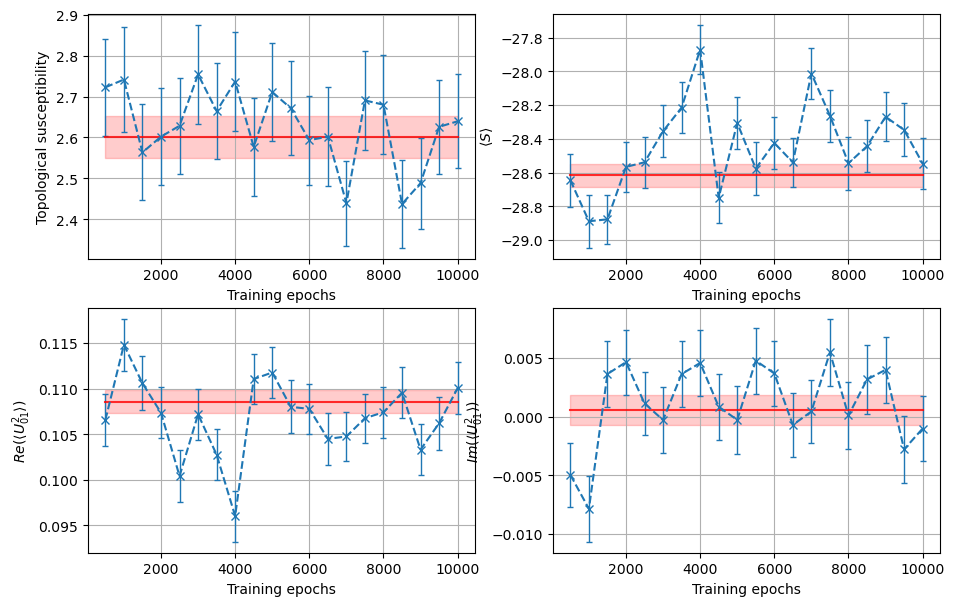

In [47]:
loading = np.load(folder_path+'observables_b1.npz')
plaq_squared_real_progress = loading['plaq_squared_real_progress']
plaq_squared_imag_progress = loading['plaq_squared_imag_progress']
action_progress = loading['action_progress']
topo_susc_progress = loading['topo_susc_progress']

plt.rcParams["errorbar.capsize"] = 2

x_axis = np.arange(0, (n_savepoints)*n_epochs, n_epochs)

fig,ax = plt.subplots(2,2,figsize=(11,7))

start=1

ax[0,0].errorbar(x_axis[start:],topo_susc_progress[start:,0], yerr=topo_susc_progress[start:,1],fmt='x--',elinewidth=1)
ax[0,0].set_xlabel('Training epochs')
ax[0,0].set_ylabel('Topological susceptibility')
ax[0,0].plot(x_axis[start:],np.ones_like(x_axis[start:])*(topo_susc_trainset_mean), 'r-',alpha=0.8)
ax[0,0].fill_between(x_axis[start:], np.ones_like(x_axis[start:])*(topo_susc_trainset_mean-topo_susc_trainset_error),
                np.ones_like(x_axis[start:])*(topo_susc_trainset_mean+topo_susc_trainset_error),alpha=0.2, color='red')
ax[0,0].grid()

ax[0,1].errorbar(x_axis[start:],action_progress[start:,0], yerr=action_progress[start:,1],fmt='x--',elinewidth=1)
ax[0,1].set_xlabel('Training epochs')
ax[0,1].set_ylabel(r'$\langle S \rangle$')
ax[0,1].plot(x_axis[start:],np.ones_like(x_axis[start:])*action_trainset_mean,'r-',alpha=0.8)
ax[0,1].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(action_trainset_mean-action_trainset_error),
                     np.ones_like(x_axis[start:])*(action_trainset_mean+action_trainset_error),
                     alpha=0.2, color='red')
ax[0,1].grid()

ax[1,0].errorbar(x_axis[start:],plaq_squared_real_progress[start:,0], yerr=plaq_squared_real_progress[start:,1],
                 fmt='x--',elinewidth=1)
ax[1,0].set_xlabel('Training epochs')
ax[1,0].set_ylabel(r'$Re(\langle U_{01}^2 \rangle)$')
ax[1,0].plot(x_axis[start:],np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean),'r-',alpha=0.8)
ax[1,0].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean-plaq_squared_real_trainset_error),
                     np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean+plaq_squared_real_trainset_error),
                     alpha=0.2, color='red')
ax[1,0].grid()

ax[1,1].errorbar(x_axis[start:],plaq_squared_imag_progress[start:,0], yerr=plaq_squared_imag_progress[start:,1],
                 fmt='x--',elinewidth=1)
ax[1,1].set_xlabel('Training epochs')
ax[1,1].set_ylabel(r'$Im(\langle U_{01}^2 \rangle)$')
ax[1,1].plot(x_axis[start:],np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean),'r-',alpha=0.8)
ax[1,1].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean-plaq_squared_imag_trainset_error),
                     np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean+plaq_squared_imag_trainset_error),
                     alpha=0.2, color='red')
ax[1,1].grid()

plt.show()

In [ ]:
ess_progress = np.zeros((n_savepoints))

generated_samples_progress = torch.load(folder_path+'generated_samples_b1.pt')
skilling_batch_size = generated_samples_progress.shape[1]

for i in range(n_savepoints):
    generated_samples = generated_samples_progress[i]
    network = ScoreModel().to(device)
    checkpoint = torch.load(folder_path+'score_net_b1_{0}.pt'.format(i))
    network.load_state_dict(checkpoint['model_state_dict'])
    
    log_p_0_theory = - action(generated_samples, beta=1., u1_bool=True).cpu()
    log_p_0_model = log_p_0_skilling(generated_samples.to(device)).cpu()
    
    ess_progress[i] = ess(log_p_0_model, log_p_0_theory).numpy()
    
    print('After ',i*n_epochs,' epochs: ESS = ',ess_progress[i])
    
np.savez(folder_path+'ess_b1.npz', ess_progress=ess_progress)

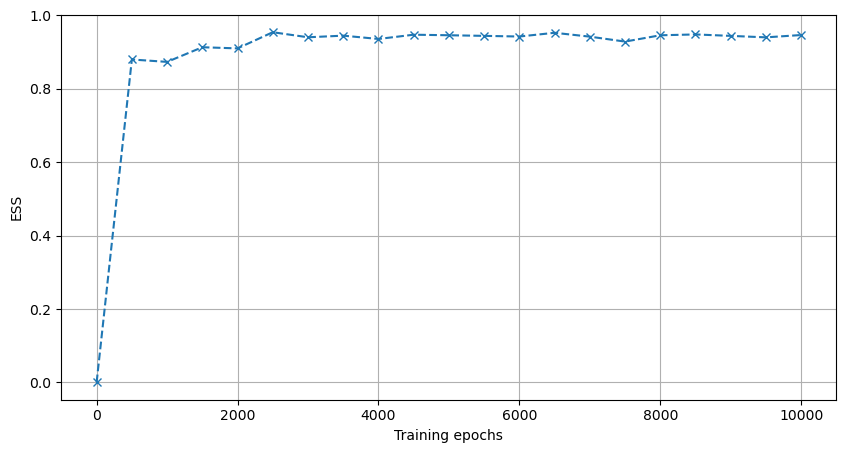

In [50]:
loading = np.load(folder_path+'ess_b1.npz')
ess_progress = loading['ess_progress']

x_axis = np.arange(0, (n_savepoints)*n_epochs, n_epochs)

plt.figure(figsize=(10,5))
plt.plot(x_axis,ess_progress,'x--')
plt.xlabel('Training epochs')
plt.ylabel('ESS')
plt.grid()
plt.show()

### Observables

In [57]:
generated_samples = solve_sde(10000).cpu()

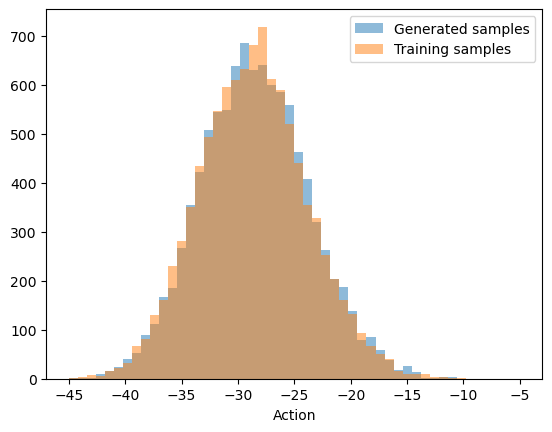

In [58]:
plt.hist(action(generated_samples, beta=1.).numpy(), bins=50, alpha=0.5, 
         label='Generated samples', range=(-45,-5))
plt.hist(action(training_samples, beta=1.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Training samples', range=(-45,-5))
plt.legend()
plt.xlabel('Action')
plt.show()

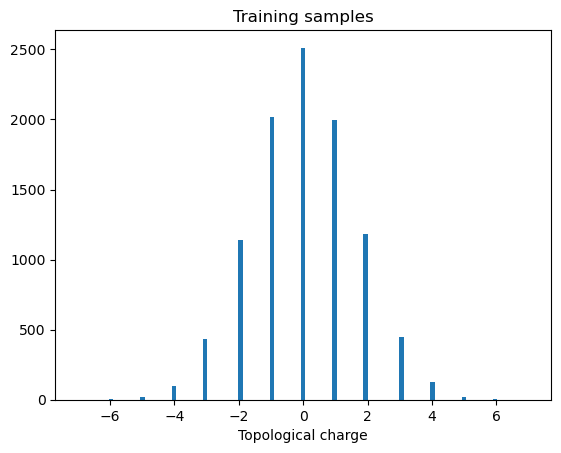

In [59]:
plt.hist(topological_charge(training_samples).cpu().numpy(), bins=101, range=(-7,7))
plt.xlabel('Topological charge')
plt.title('Training samples')
plt.show()

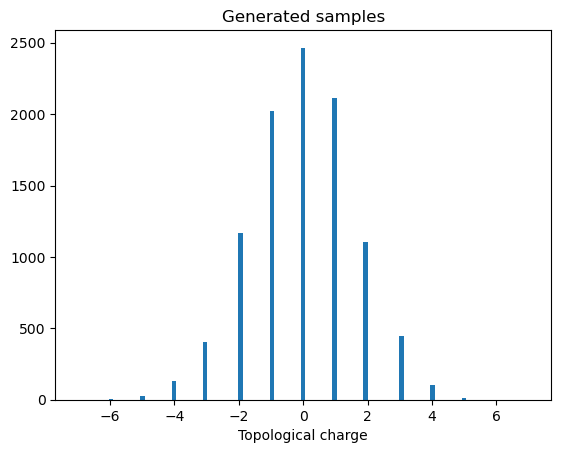

In [60]:
plt.hist(topological_charge(generated_samples).numpy(), bins=101, range=(-7,7))
plt.xlabel('Topological charge')
plt.title('Generated samples')
plt.show()

Topological susceptibility:

In [61]:
mean, var = jackknife(generated_samples,topological_susceptibility)
print('Generated samples: ', mean, ' +- ', var)

Generated samples:  2.581  +-  0.05124985480737558


In [62]:
mean, var = jackknife(training_samples,topological_susceptibility)
print('Training samples: ', mean, ' +- ', var)

Training samples:  2.601  +-  0.05215560597142627


### Model probability calc

In [63]:
skilling_batch_size = 2000
generated_samples = solve_sde(skilling_batch_size)

In [64]:
log_p_0_model = log_p_0_skilling(generated_samples).cpu()

In [65]:
log_p_0_theory = - action(generated_samples, beta=1., u1_bool=True).cpu()

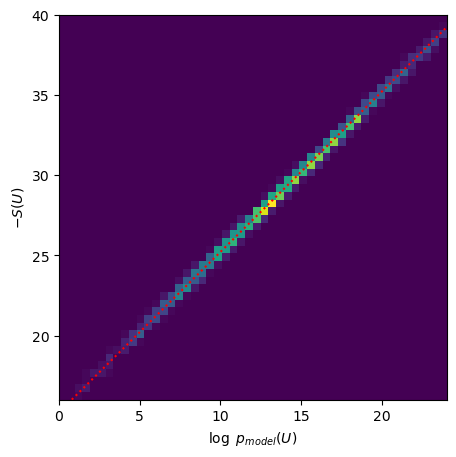

In [66]:
S = -log_p_0_theory.numpy()
S_eff = -log_p_0_model.numpy()
fit_b = np.mean(-S) - np.mean(-S_eff)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist2d(log_p_0_model.numpy(), log_p_0_theory.numpy(), bins=50, range=((0.,24.),(16.,40.)))
ax.set_xlabel(r'$\log~p_{model}(U)$')
ax.set_ylabel(r'$-S(U)$')
xs = np.linspace(-500, 500, num=10)
ax.plot(xs, xs + fit_b, ':', color='r', label='slope 1 fit')
plt.show()

Metropolis sampling

In [67]:
ess(log_p_0_model, log_p_0_theory)

tensor(0.9488)

In [68]:
metro_samples = independence_metropolis(generated_samples, log_p_0_model, log_p_0_theory)

Acceptance rate:  0.871


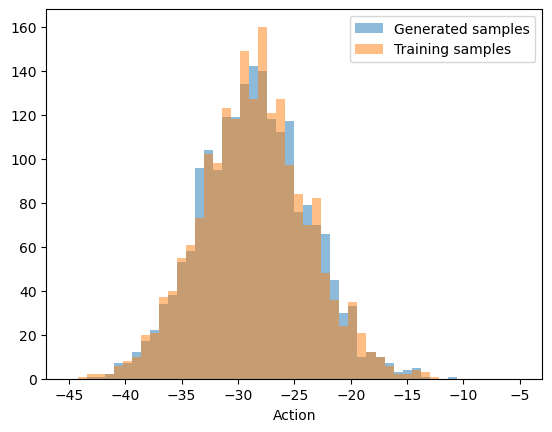

In [69]:
plt.hist(action(metro_samples, beta=1.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Generated samples', range=(-45,-5))
plt.hist(action(training_samples[0:metro_samples.shape[0]], beta=1.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Training samples', range=(-45,-5))
plt.legend()
plt.xlabel('Action')
plt.show()

## $\beta=2$

In [70]:
training_samples = torch.load(r'beta_2_grid_8.pt')

training_samples = torch.exp(1.j * training_samples)

In [ ]:
network = ScoreModel().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [ ]:
train_score_loss(3000, training_samples, batch_size=100)

#### Save training progress

In [71]:
folder_path =  r'/'

In [72]:
n_savepoints = 21
n_epochs = 500

In [ ]:
network = ScoreModel().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9997)

for i in range(n_savepoints):
    torch.save({'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, folder_path+'score_net_b2_{0}.pt'.format(i))
    
    train_score_loss(n_epochs, training_samples, batch_size=1000)


In [ ]:
n_generate = 2000
generated_samples_progress = torch.zeros((n_savepoints, n_generate, 2, grid_size, grid_size), dtype=torch.complex64)
for i in range(n_savepoints):
    network = ScoreModel().to(device)
    checkpoint = torch.load(folder_path+'score_net_b2_{0}.pt'.format(i))
    network.load_state_dict(checkpoint['model_state_dict'])
    
    generated_samples_progress[i] = solve_sde(n_generate).cpu().detach()
    
torch.save(generated_samples_progress, folder_path+'generated_samples_b2.pt')


In [ ]:
def action_mean_func_b2(samples):
    return action_mean_func(samples, beta=2.)

In [ ]:
plaq_squared_real_progress = np.zeros((n_savepoints,2))
plaq_squared_imag_progress = np.zeros((n_savepoints,2))
action_progress = np.zeros((n_savepoints,2))
topo_susc_progress = np.zeros((n_savepoints,2))

generated_samples_progress = torch.load(folder_path+'generated_samples_b2.pt')

for i in range(n_savepoints):
    generated_samples = generated_samples_progress[i]
    
    plaq_squared_real_progress[i,0], plaq_squared_real_progress[i,1] = jackknife(generated_samples, plaq_squared_real_func)
    plaq_squared_imag_progress[i,0], plaq_squared_imag_progress[i,1] = jackknife(generated_samples, plaq_squared_imag_func)
    action_progress[i,0], action_progress[i,1] = jackknife(generated_samples, action_mean_func_b2)
    topo_susc_progress[i,0], topo_susc_progress[i,1] = jackknife(generated_samples, topological_susceptibility)
    
np.savez(folder_path+'observables_b2.npz', plaq_squared_real_progress=plaq_squared_real_progress, 
        plaq_squared_imag_progress=plaq_squared_imag_progress, action_progress=action_progress,
        topo_susc_progress=topo_susc_progress)

In [ ]:
action_trainset_mean, action_trainset_error = jackknife(training_samples, action_mean_func_b2)
plaq_squared_real_trainset_mean, plaq_squared_real_trainset_error = jackknife(training_samples, plaq_squared_real_func)
plaq_squared_imag_trainset_mean, plaq_squared_imag_trainset_error = jackknife(training_samples, plaq_squared_imag_func)
topo_susc_trainset_mean, topo_susc_trainset_error = jackknife(training_samples, topological_susceptibility)

np.savez(folder_path+'training_samples_observables_b2.npz', 
        action_trainset_mean=action_trainset_mean,
        action_trainset_error=action_trainset_error, 
        plaq_squared_real_trainset_mean=plaq_squared_real_trainset_mean,
        plaq_squared_real_trainset_error=plaq_squared_real_trainset_error, 
        plaq_squared_imag_trainset_mean=plaq_squared_imag_trainset_mean,
        plaq_squared_imag_trainset_error=plaq_squared_imag_trainset_error,
        topo_susc_trainset_mean=topo_susc_trainset_mean, 
        topo_susc_trainset_error=topo_susc_trainset_error)

In [73]:
loading = np.load(folder_path+'training_samples_observables_b2.npz')
action_trainset_mean = loading['action_trainset_mean']
action_trainset_error = loading['action_trainset_error']
plaq_squared_real_trainset_mean = loading['plaq_squared_real_trainset_mean']
plaq_squared_real_trainset_error = loading['plaq_squared_real_trainset_error']
plaq_squared_imag_trainset_mean = loading['plaq_squared_imag_trainset_mean']
plaq_squared_imag_trainset_error = loading['plaq_squared_imag_trainset_error']
topo_susc_trainset_mean = loading['topo_susc_trainset_mean']
topo_susc_trainset_error = loading['topo_susc_trainset_error']

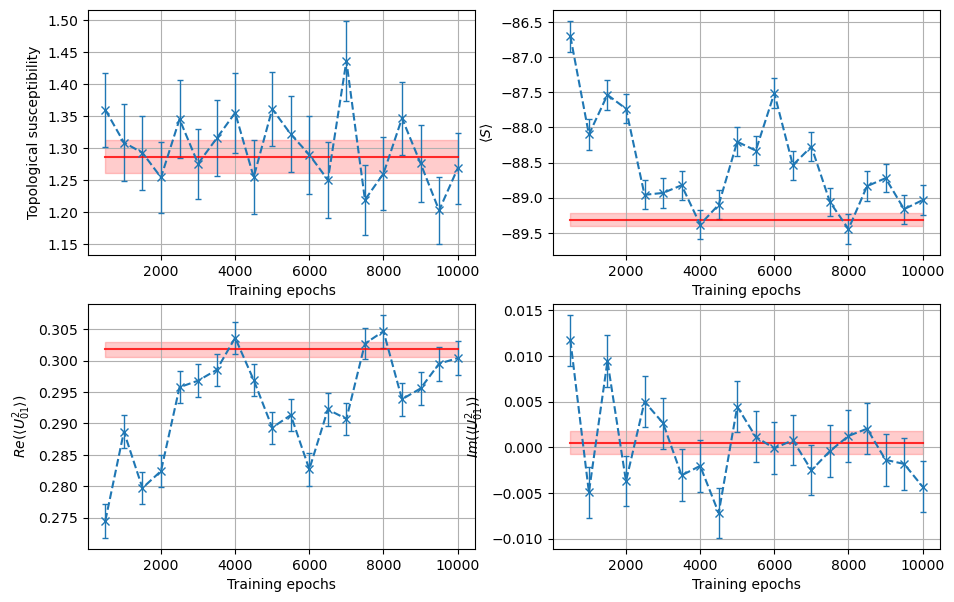

In [74]:
loading = np.load(folder_path+'observables_b2.npz')
plaq_squared_real_progress = loading['plaq_squared_real_progress']
plaq_squared_imag_progress = loading['plaq_squared_imag_progress']
action_progress = loading['action_progress']
topo_susc_progress = loading['topo_susc_progress']

plt.rcParams["errorbar.capsize"] = 2

x_axis = np.arange(0, (n_savepoints)*n_epochs, n_epochs)

fig,ax = plt.subplots(2,2,figsize=(11,7))

start=1

ax[0,0].errorbar(x_axis[start:],topo_susc_progress[start:,0], yerr=topo_susc_progress[start:,1],fmt='x--',elinewidth=1)
ax[0,0].set_xlabel('Training epochs')
ax[0,0].set_ylabel('Topological susceptibility')
ax[0,0].plot(x_axis[start:],np.ones_like(x_axis[start:])*(topo_susc_trainset_mean), 'r-',alpha=0.8)
ax[0,0].fill_between(x_axis[start:], np.ones_like(x_axis[start:])*(topo_susc_trainset_mean-topo_susc_trainset_error),
                np.ones_like(x_axis[start:])*(topo_susc_trainset_mean+topo_susc_trainset_error),alpha=0.2, color='red')
ax[0,0].grid()

ax[0,1].errorbar(x_axis[start:],action_progress[start:,0], yerr=action_progress[start:,1],fmt='x--',elinewidth=1)
ax[0,1].set_xlabel('Training epochs')
ax[0,1].set_ylabel(r'$\langle S \rangle$')
ax[0,1].plot(x_axis[start:],np.ones_like(x_axis[start:])*action_trainset_mean,'r-',alpha=0.8)
ax[0,1].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(action_trainset_mean-action_trainset_error),
                     np.ones_like(x_axis[start:])*(action_trainset_mean+action_trainset_error),
                     alpha=0.2, color='red')
ax[0,1].grid()

ax[1,0].errorbar(x_axis[start:],plaq_squared_real_progress[start:,0], yerr=plaq_squared_real_progress[start:,1],
                 fmt='x--',elinewidth=1)
ax[1,0].set_xlabel('Training epochs')
ax[1,0].set_ylabel(r'$Re(\langle U_{01}^2 \rangle)$')
ax[1,0].plot(x_axis[start:],np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean),'r-',alpha=0.8)
ax[1,0].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean-plaq_squared_real_trainset_error),
                     np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean+plaq_squared_real_trainset_error),
                     alpha=0.2, color='red')
ax[1,0].grid()

ax[1,1].errorbar(x_axis[start:],plaq_squared_imag_progress[start:,0], yerr=plaq_squared_imag_progress[start:,1],
                 fmt='x--',elinewidth=1)
ax[1,1].set_xlabel('Training epochs')
ax[1,1].set_ylabel(r'$Im(\langle U_{01}^2 \rangle)$')
ax[1,1].plot(x_axis[start:],np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean),'r-',alpha=0.8)
ax[1,1].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean-plaq_squared_imag_trainset_error),
                     np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean+plaq_squared_imag_trainset_error),
                     alpha=0.2, color='red')
ax[1,1].grid()

plt.show()

In [ ]:
ess_progress = np.zeros((n_savepoints))
log_p_0_theory_progress = np.zeros((n_savepoints, n_generate))
log_p_0_model_progress = np.zeros((n_savepoints, n_generate))

generated_samples_progress = torch.load(folder_path+'generated_samples_b2.pt')
skilling_batch_size = generated_samples_progress.shape[1]

for i in range(n_savepoints):
    generated_samples = generated_samples_progress[i]
    network = ScoreModel().to(device)
    checkpoint = torch.load(folder_path+'score_net_b2_{0}.pt'.format(i))
    network.load_state_dict(checkpoint['model_state_dict'])
    
    log_p_0_theory = - action(generated_samples, beta=2., u1_bool=True).cpu()
    log_p_0_model = log_p_0_skilling(generated_samples.to(device)).cpu()
    
    log_p_0_theory_progress[i] = log_p_0_theory
    log_p_0_model_progress[i] = log_p_0_model
    ess_progress[i] = ess(log_p_0_model, log_p_0_theory).numpy()
    
    print('After ',i*n_epochs,' epochs: ESS = ',ess_progress[i])
    
np.savez(folder_path+'ess_b2.npz', ess_progress=ess_progress, log_p_0_theory_progress=log_p_0_theory_progress,
        log_p_0_model_progress=log_p_0_model_progress)

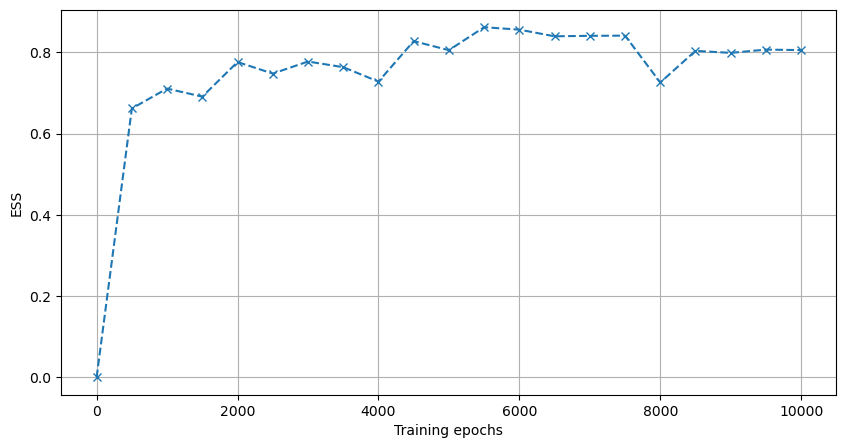

In [75]:
loading = np.load(folder_path+'ess_b2.npz')
ess_progress = loading['ess_progress']

x_axis = np.arange(0, (n_savepoints)*n_epochs, n_epochs)

plt.figure(figsize=(10,5))
plt.plot(x_axis,ess_progress,'x--')
plt.xlabel('Training epochs')
plt.ylabel('ESS')
plt.grid()
plt.show()

### Observables

Action:

In [77]:
generated_samples = solve_sde(10000).cpu()

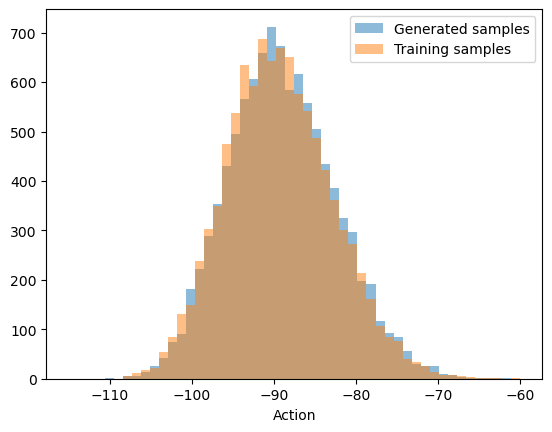

In [78]:
plt.hist(action(generated_samples, beta=2.).numpy(), bins=50, alpha=0.5, 
         label='Generated samples', range=(-115,-60))
plt.hist(action(training_samples, beta=2.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Training samples', range=(-115,-60))
plt.legend()
plt.xlabel('Action')
plt.show()

In [79]:
def action_mean_func_b2(samples):
    return action_mean_func(samples, beta=2.)

In [80]:
mean, var = jackknife(generated_samples,action_mean_func_b2)
print('Generated samples: ', mean, ' +- ', var)

Generated samples:  -88.97921  +-  0.09230141586616243


In [81]:
mean, var = jackknife(training_samples,action_mean_func_b2)
print('Training samples: ', mean, ' +- ', var)

Training samples:  -89.31517  +-  0.09184127151313372


Topological charge

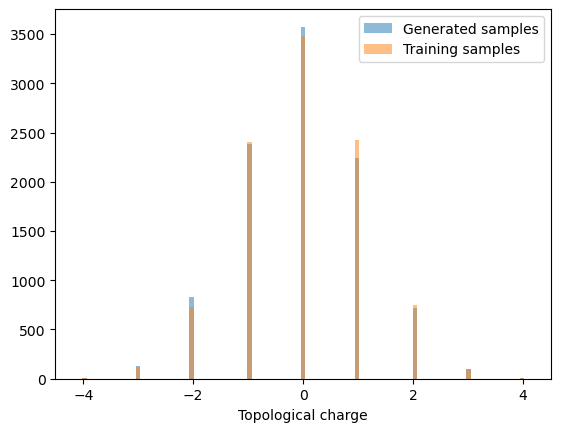

In [82]:
plt.hist(topological_charge(generated_samples).cpu().numpy(), bins=101, alpha=0.5, 
         label='Generated samples', range=(-4.1,4.1))
plt.hist(topological_charge(training_samples).cpu().numpy(), bins=101, alpha=0.5, 
         label='Training samples', range=(-4.1,4.1))
plt.xlabel('Topological charge')
plt.legend()
plt.show()

Topological susceptibility

In [83]:
mean, var = jackknife(generated_samples,topological_susceptibility)
print('Generated samples: ', mean, ' +- ', var)

Generated samples:  1.3191  +-  0.026617557126330193


In [84]:
mean, var = jackknife(training_samples,topological_susceptibility)
print('Training samples: ', mean, ' +- ', var)

Training samples:  1.2863  +-  0.025803077605937533


### Model probability

In [85]:
skilling_batch_size = 2000
generated_samples = solve_sde(skilling_batch_size)

In [86]:
log_p_0_model = log_p_0_skilling(generated_samples).cpu()

In [87]:
log_p_0_theory = - action(generated_samples, beta=2., u1_bool=True).cpu()

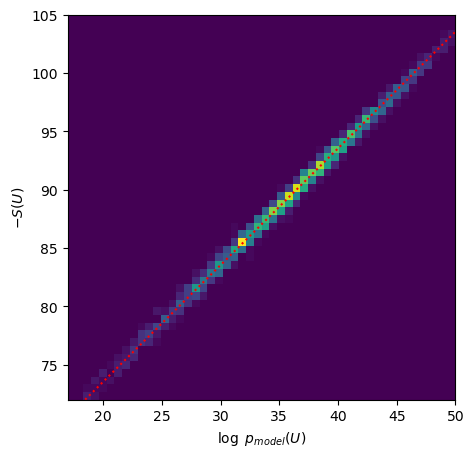

In [88]:
S = -log_p_0_theory.numpy()
S_eff = -log_p_0_model.numpy()
fit_b = np.mean(-S) - np.mean(-S_eff)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist2d(log_p_0_model.numpy(), log_p_0_theory.numpy(), bins=50, range=((17.,50.),(72.,105.)))
ax.set_xlabel(r'$\log~p_{model}(U)$')
ax.set_ylabel(r'$-S(U)$')
xs = np.linspace(-500, 500, num=10)
ax.plot(xs, xs + fit_b, ':', color='r', label='slope 1 fit')
plt.show()

#### Metropolis sampling

In [89]:
ess(log_p_0_model, log_p_0_theory)

tensor(0.8087)

In [90]:
metro_samples = independence_metropolis(generated_samples, log_p_0_model, log_p_0_theory)

Acceptance rate:  0.8005


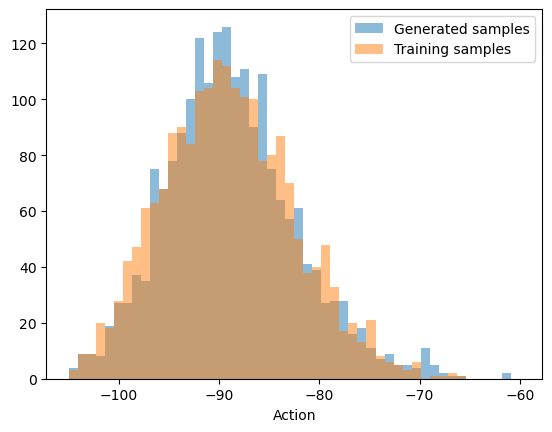

In [91]:
plt.hist(action(metro_samples, beta=2.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Generated samples', range=(-105,-60))
plt.hist(action(training_samples[0:metro_samples.shape[0]], beta=2.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Training samples', range=(-105,-60))
plt.legend()
plt.xlabel('Action')
plt.show()

## Go to a bigger grid for $\beta=2$

ESS = 0.80 for a 8x8 grid

In [40]:
network = ScoreModel().to(device)
checkpoint = torch.load(folder_path+'score_net_b2_20.pt')
network.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [41]:
grid_size = 16

In [42]:
training_samples = torch.load(r'beta_2_grid_16.pt')

training_samples = torch.exp(1.j * training_samples)

Action:

In [43]:
generated_samples = solve_sde(10000).cpu()

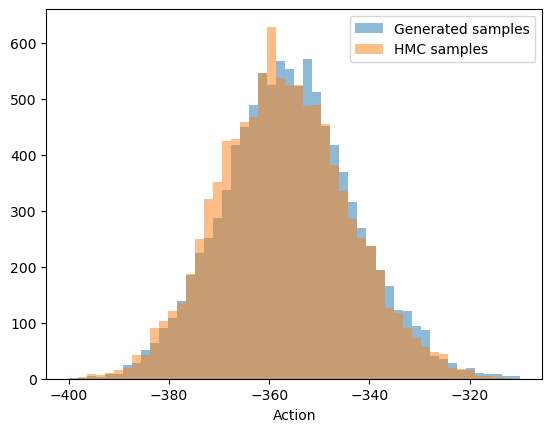

In [44]:
plt.hist(action(generated_samples, beta=2.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Generated samples', range=(-400,-310))
plt.hist(action(training_samples, beta=2.).cpu().numpy(), bins=50, alpha=0.5, 
         label='HMC samples', range=(-400,-310))
plt.legend()
plt.xlabel('Action')
plt.show()

In [45]:
def action_mean_func_b2(samples):
    return action_mean_func(samples, beta=2.)

In [46]:
mean, var = jackknife(generated_samples,action_mean_func_b2)
print('Generated samples: ', mean, ' +- ', var)

Generated samples:  -355.90375  +-  0.18553079894568464


In [47]:
mean, var = jackknife(training_samples,action_mean_func_b2)
print('Training samples: ', mean, ' +- ', var)

Training samples:  -357.08878  +-  0.1838781968366489


Topological Susceptibility:

In [48]:
mean, var = jackknife(generated_samples,topological_susceptibility)
print('Generated samples: ', mean, ' +- ', var)

Generated samples:  5.2162  +-  0.10467249688217718


In [49]:
mean, var = jackknife(training_samples,topological_susceptibility)
print('Training samples: ', mean, ' +- ', var)

Training samples:  5.0541  +-  0.10089477194651693


ESS:

In [50]:
skilling_batch_size = 2000
generated_samples = solve_sde(2000).cpu()

In [51]:
log_p_0_model = log_p_0_skilling(generated_samples.to(device)).cpu()

In [52]:
log_p_0_theory = - action(generated_samples, beta=2., u1_bool=True).cpu()

In [53]:
ess(log_p_0_model, log_p_0_theory)

tensor(0.3926)

In [54]:
0.80**(16**2/8**2)

0.4096000000000001

#### Even bigger grid

In [55]:
grid_size = 25

In [56]:
skilling_batch_size = 2000
generated_samples = solve_sde(2000).cpu()

In [57]:
log_p_0_model = log_p_0_skilling(generated_samples.to(device)).cpu()

In [58]:
log_p_0_theory = - action(generated_samples, beta=2., u1_bool=True).cpu()

In [59]:
ess(log_p_0_model, log_p_0_theory)

tensor(0.1689)

In [60]:
0.80**(25**2/8**2)

0.11313921320050851

## $\beta=5$

In [38]:
training_samples = torch.load(r'beta_5_grid_8.pt')

training_samples = torch.exp(1.j * training_samples)

In [ ]:
network = ScoreModel().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [ ]:
train_score_loss(5000, training_samples, batch_size=200)

### Save training progress

In [39]:
folder_path =  r'/'


In [40]:
n_savepoints = 21
n_epochs = 5000

In [ ]:
network = ScoreModel().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

for i in range(n_savepoints):
    torch.save({'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, folder_path+'score_net_b5_{0}.pt'.format(i))
    
    if i < (n_savepoints-1):
        train_score_loss(n_epochs, training_samples, batch_size=1000)


In [ ]:
n_generate = 2000
generated_samples_progress = torch.zeros((n_savepoints, n_generate, 2, grid_size, grid_size), dtype=torch.complex64)
for i in range(n_savepoints):
    network = ScoreModel().to(device)
    checkpoint = torch.load(folder_path+'score_net_b5_{0}.pt'.format(i))
    network.load_state_dict(checkpoint['model_state_dict'])
    
    generated_samples_progress[i] = solve_sde(n_generate).cpu().detach()
    
torch.save(generated_samples_progress, folder_path+'generated_samples_b5.pt')


In [ ]:
def action_mean_func_b5(samples):
    return action_mean_func(samples, beta=5.)

In [ ]:
plaq_squared_real_progress = np.zeros((n_savepoints,2))
plaq_squared_imag_progress = np.zeros((n_savepoints,2))
action_progress = np.zeros((n_savepoints,2))
topo_susc_progress = np.zeros((n_savepoints,2))

generated_samples_progress = torch.load(folder_path+'generated_samples_b5.pt')

for i in range(n_savepoints):
    generated_samples = generated_samples_progress[i]
    
    plaq_squared_real_progress[i,0], plaq_squared_real_progress[i,1] = jackknife(generated_samples, plaq_squared_real_func)
    plaq_squared_imag_progress[i,0], plaq_squared_imag_progress[i,1] = jackknife(generated_samples, plaq_squared_imag_func)
    action_progress[i,0], action_progress[i,1] = jackknife(generated_samples, action_mean_func_b5)
    topo_susc_progress[i,0], topo_susc_progress[i,1] = jackknife(generated_samples, topological_susceptibility)
    
np.savez(folder_path+'observables_b5.npz', plaq_squared_real_progress=plaq_squared_real_progress, 
        plaq_squared_imag_progress=plaq_squared_imag_progress, action_progress=action_progress,
        topo_susc_progress=topo_susc_progress)

In [ ]:
action_trainset_mean, action_trainset_error = jackknife(training_samples, action_mean_func_b5)
plaq_squared_real_trainset_mean, plaq_squared_real_trainset_error = jackknife(training_samples, plaq_squared_real_func)
plaq_squared_imag_trainset_mean, plaq_squared_imag_trainset_error = jackknife(training_samples, plaq_squared_imag_func)
topo_susc_trainset_mean, topo_susc_trainset_error = jackknife(training_samples, topological_susceptibility)

np.savez(folder_path+'training_samples_observables_b5.npz', 
        action_trainset_mean=action_trainset_mean,
        action_trainset_error=action_trainset_error, 
        plaq_squared_real_trainset_mean=plaq_squared_real_trainset_mean,
        plaq_squared_real_trainset_error=plaq_squared_real_trainset_error, 
        plaq_squared_imag_trainset_mean=plaq_squared_imag_trainset_mean,
        plaq_squared_imag_trainset_error=plaq_squared_imag_trainset_error,
        topo_susc_trainset_mean=topo_susc_trainset_mean, 
        topo_susc_trainset_error=topo_susc_trainset_error)

In [37]:
loading = np.load(folder_path+'training_samples_observables_b5.npz')
action_trainset_mean = loading['action_trainset_mean']
action_trainset_error = loading['action_trainset_error']
plaq_squared_real_trainset_mean = loading['plaq_squared_real_trainset_mean']
plaq_squared_real_trainset_error = loading['plaq_squared_real_trainset_error']
plaq_squared_imag_trainset_mean = loading['plaq_squared_imag_trainset_mean']
plaq_squared_imag_trainset_error = loading['plaq_squared_imag_trainset_error']
topo_susc_trainset_mean = loading['topo_susc_trainset_mean']
topo_susc_trainset_error = loading['topo_susc_trainset_error']

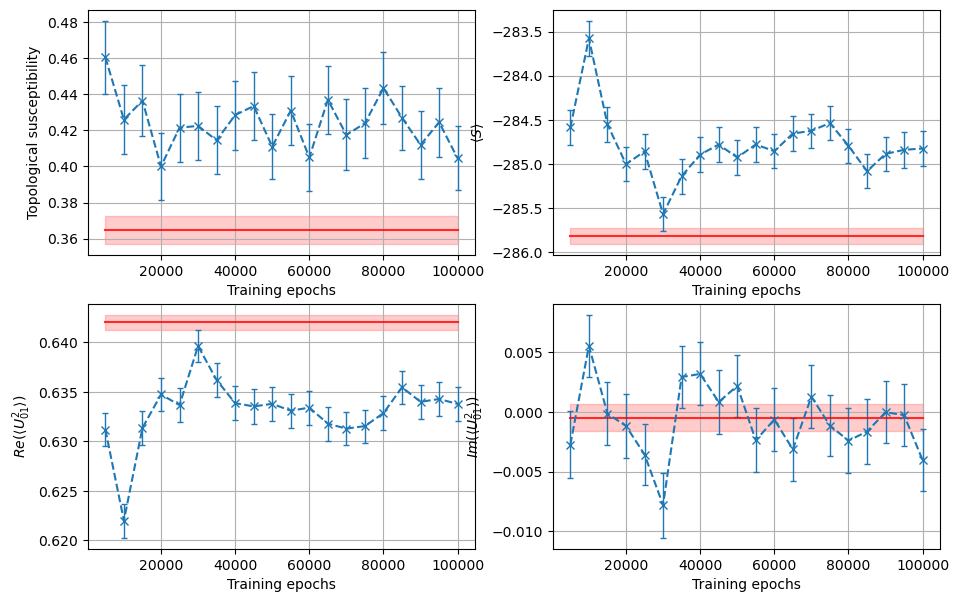

In [40]:
loading = np.load(folder_path+'observables_b5.npz')
plaq_squared_real_progress = loading['plaq_squared_real_progress']
plaq_squared_imag_progress = loading['plaq_squared_imag_progress']
action_progress = loading['action_progress']
topo_susc_progress = loading['topo_susc_progress']

plt.rcParams["errorbar.capsize"] = 2

x_axis = np.arange(0, (n_savepoints)*n_epochs, n_epochs)

fig,ax = plt.subplots(2,2,figsize=(11,7))

start=1

ax[0,0].errorbar(x_axis[start:],topo_susc_progress[start:,0], yerr=topo_susc_progress[start:,1],fmt='x--',elinewidth=1)
ax[0,0].set_xlabel('Training epochs')
ax[0,0].set_ylabel('Topological susceptibility')
ax[0,0].plot(x_axis[start:],np.ones_like(x_axis[start:])*(topo_susc_trainset_mean), 'r-',alpha=0.8)
ax[0,0].fill_between(x_axis[start:], np.ones_like(x_axis[start:])*(topo_susc_trainset_mean-topo_susc_trainset_error),
                np.ones_like(x_axis[start:])*(topo_susc_trainset_mean+topo_susc_trainset_error),alpha=0.2, color='red')
ax[0,0].grid()

ax[0,1].errorbar(x_axis[start:],action_progress[start:,0], yerr=action_progress[start:,1],fmt='x--',elinewidth=1)
ax[0,1].set_xlabel('Training epochs')
ax[0,1].set_ylabel(r'$\langle S \rangle$')
ax[0,1].plot(x_axis[start:],np.ones_like(x_axis[start:])*action_trainset_mean,'r-',alpha=0.8)
ax[0,1].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(action_trainset_mean-action_trainset_error),
                     np.ones_like(x_axis[start:])*(action_trainset_mean+action_trainset_error),
                     alpha=0.2, color='red')
ax[0,1].grid()

ax[1,0].errorbar(x_axis[start:],plaq_squared_real_progress[start:,0], yerr=plaq_squared_real_progress[start:,1],
                 fmt='x--',elinewidth=1)
ax[1,0].set_xlabel('Training epochs')
ax[1,0].set_ylabel(r'$Re(\langle U_{01}^2 \rangle)$')
ax[1,0].plot(x_axis[start:],np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean),'r-',alpha=0.8)
ax[1,0].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean-plaq_squared_real_trainset_error),
                     np.ones_like(x_axis[start:])*(plaq_squared_real_trainset_mean+plaq_squared_real_trainset_error),
                     alpha=0.2, color='red')
ax[1,0].grid()

ax[1,1].errorbar(x_axis[start:],plaq_squared_imag_progress[start:,0], yerr=plaq_squared_imag_progress[start:,1],
                 fmt='x--',elinewidth=1)
ax[1,1].set_xlabel('Training epochs')
ax[1,1].set_ylabel(r'$Im(\langle U_{01}^2 \rangle)$')
ax[1,1].plot(x_axis[start:],np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean),'r-',alpha=0.8)
ax[1,1].fill_between(x_axis[start:], 
                     np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean-plaq_squared_imag_trainset_error),
                     np.ones_like(x_axis[start:])*(plaq_squared_imag_trainset_mean+plaq_squared_imag_trainset_error),
                     alpha=0.2, color='red')
ax[1,1].grid()

plt.show()

In [ ]:
ess_progress = np.zeros((n_savepoints))

generated_samples_progress = torch.load(folder_path+'generated_samples_b5.pt')
skilling_batch_size = generated_samples_progress.shape[1]

for i in range(n_savepoints):
    generated_samples = generated_samples_progress[i]
    network = ScoreModel().to(device)
    checkpoint = torch.load(folder_path+'score_net_b5_{0}.pt'.format(i))
    network.load_state_dict(checkpoint['model_state_dict'])
    
    log_p_0_theory = - action(generated_samples, beta=5., u1_bool=True).cpu()
    log_p_0_model = log_p_0_skilling(generated_samples.to(device)).cpu()
    
    ess_progress[i] = ess(log_p_0_model, log_p_0_theory).numpy()
    
    print('After ',i*n_epochs,' epochs: ESS = ',ess_progress[i])
    
np.savez(folder_path+'ess_b5.npz', ess_progress=ess_progress)

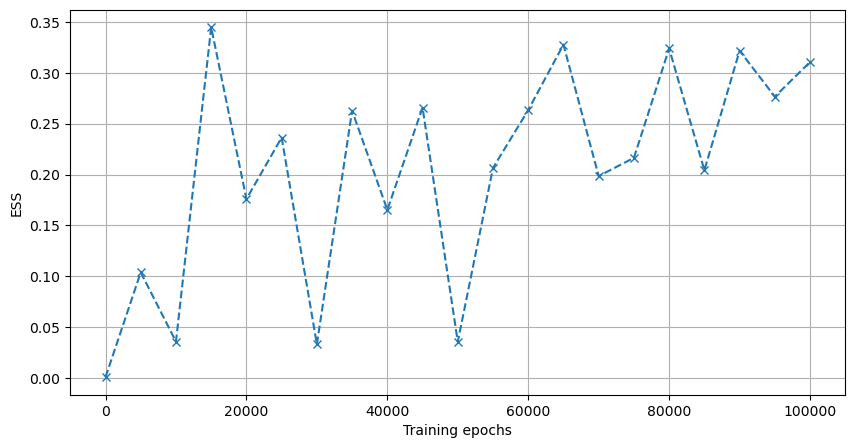

In [41]:
loading = np.load(folder_path+'ess_b5.npz')
ess_progress = loading['ess_progress']

x_axis = np.arange(0, (n_savepoints)*n_epochs, n_epochs)

plt.figure(figsize=(10,5))
plt.plot(x_axis,ess_progress,'x--')
plt.xlabel('Training epochs')
plt.ylabel('ESS')
plt.grid()
plt.show()

### Observables

In [43]:
generated_samples = solve_sde(10000).cpu()

Action:

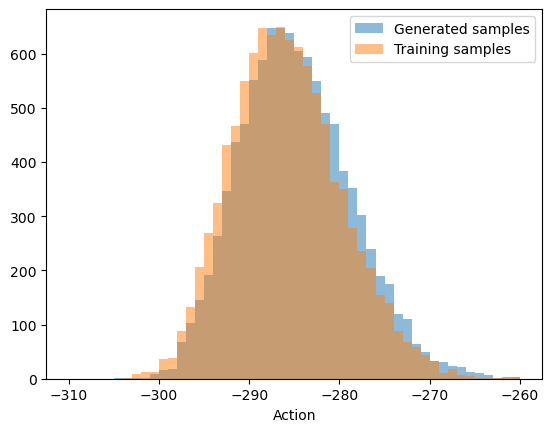

In [44]:
plt.hist(action(generated_samples, beta=5.).numpy(), bins=50, alpha=0.5, 
         label='Generated samples', range=(-310,-260))
plt.hist(action(training_samples, beta=5.).cpu().numpy(), bins=50, alpha=0.5, 
         label='Training samples', range=(-310,-260))
plt.legend()
plt.xlabel('Action')
plt.show()

In [45]:
def action_mean_func_b5(samples):
    return action_mean_func(samples, beta=5.)

In [46]:
mean, var = jackknife(generated_samples,action_mean_func_b5)
print('Generated samples: ', mean, ' +- ', var)

Generated samples:  -284.79745  +-  0.08845297111583508


In [47]:
mean, var = jackknife(training_samples,action_mean_func_b5)
print('Training samples: ', mean, ' +- ', var)

Training samples:  -285.81464  +-  0.0861406103370399


Topological charge:

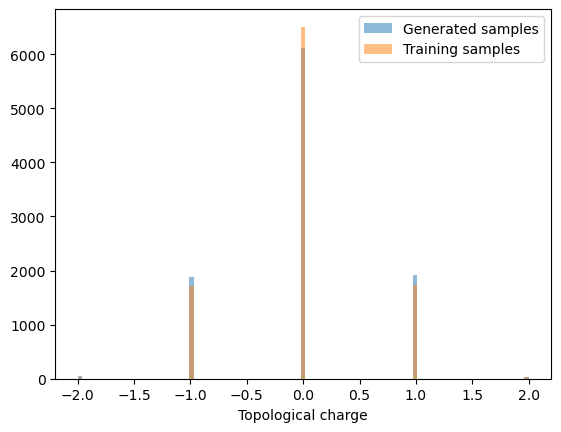

In [48]:
plt.hist(topological_charge(generated_samples).cpu().numpy(), bins=101, alpha=0.5, 
         label='Generated samples')
plt.hist(topological_charge(training_samples).cpu().numpy(), bins=101, alpha=0.5, 
         label='Training samples')
plt.xlabel('Topological charge')
plt.legend()
plt.show()

Topological susceptibility

In [49]:
mean, var = jackknife(generated_samples,topological_susceptibility)
print('Generated samples: ', mean, ' +- ', var)

Generated samples:  0.4151  +-  0.008371060870960874


In [50]:
mean, var = jackknife(training_samples,topological_susceptibility)
print('Training samples: ', mean, ' +- ', var)

Training samples:  0.3649  +-  0.007664936416325739


#### Model probability

In [56]:
network = ScoreModel().to(device)
checkpoint = torch.load(folder_path+'score_net_b5_20.pt')
network.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [57]:
skilling_batch_size = 2000
generated_samples = solve_sde(skilling_batch_size)

In [58]:
log_p_0_model = log_p_0_skilling(generated_samples).cpu()

In [59]:
log_p_0_theory = - action(generated_samples, beta=5., u1_bool=True).cpu()

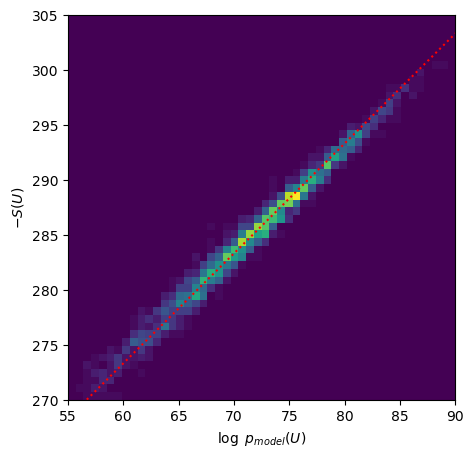

In [60]:
S = -log_p_0_theory.numpy()
S_eff = -log_p_0_model.numpy()
fit_b = np.mean(-S) - np.mean(-S_eff)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist2d(log_p_0_model.numpy(), log_p_0_theory.numpy(), bins=50, range=((55.,90.),(270.,305.)))
ax.set_xlabel(r'$\log~p_{model}(U)$')
ax.set_ylabel(r'$-S(U)$')
xs = np.linspace(-500, 500, num=10)
ax.plot(xs, xs + fit_b, ':', color='r', label='slope 1 fit')
plt.show()

Metropolis sampling

In [67]:
ess(log_p_0_model, log_p_0_theory)

tensor(0.2481)

In [68]:
metro_samples = independence_metropolis(generated_samples, log_p_0_model, log_p_0_theory)

Acceptance rate:  0.656
